# **install and import**

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ResizeWithPadOrCropd,
    SpatialCrop
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR,SwinUNETR,UNet

from monai.data import (
    CacheDataset,
    DataLoader,
    Dataset,
    load_decathlon_datalist,
    decollate_batch,
)

from monai.networks.layers import Norm
import torch

print_config()

MONAI version: 1.2.dev2312
Numpy version: 1.21.6
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 400a6a052f1b2925db6f1323a67a7cf4546403eb
MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.1.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.4.0
psutil version: 5.9.1
pandas version: 1.3.5
einops version: 0.6.1
transformers version: 4.20.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# **Data Preparation**

I want to upload the images to the cache for faster training. To achieve this, I have excluded images that contain more than 450 slices.

In [3]:
import nibabel as nib
#image list
img_files=[os.path.join(path[0],file) for path in os.walk('/kaggle/input/')   for file in path[-1]  if 'pt' in path[0] if 'vol' in file]  
len(img_files)
img_files_for_trainig=[]
for file in img_files:
    n1_img_sh = nib.load(file).header.get_data_shape()
 
    if     n1_img_sh[2]<450 :
        img_files_for_trainig.append(file)
 

In [4]:
len(img_files_for_trainig)

67

In [5]:
#segmentaim list
seg_path='/kaggle/input/liver-tumor-segmentation/segmentations/'


seg_files=[seg_path+'segmentation-'+file.split('-')[-1] for file in img_files_for_trainig]  
print(img_files_for_trainig[2],seg_files[2])

/kaggle/input/liver-tumor-segmentation/volume_pt3/volume-30.nii /kaggle/input/liver-tumor-segmentation/segmentations/segmentation-30.nii


In [6]:
#monai dataset need dictonary
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(img_files_for_trainig, seg_files)]
train_files, val_files,test_files = data_dicts[:-2], data_dicts[-2:-1],data_dicts[-1:]

In [7]:
n1_img_sh = nib.load(data_dicts[0]['image'])#.header.get_data_shape()
data = n1_img_sh.get_fdata()

data.shape

(512, 512, 276)

# **Setup transforms for training and validation**

https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d_visualization_basic.ipynb

https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb



Here we use several transforms to augment the dataset:

    LoadImaged loads the liver CT images and labels from NIfTI format files.
    EnsureChannelFirstd ensures the original data to construct "channel first" shape.
    Spacingd adjusts the spacing by pixdim=(1.5, 1.5, 2.) based on the affine matrix.
    Orientationd unifies the data orientation based on the affine matrix.
    ScaleIntensityRanged extracts intensity range [-57, 164] and scales to [0, 1].
    CropForegroundd removes all zero borders to focus on the valid body area of the images and labels.
    
    RandCropByPosNegLabeld randomly crop patch samples from big image based on pos / neg ratio.

The image centers of negative samples must be in valid body area.

    RandAffined efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.
    EnsureTyped converts the numpy array to PyTorch Tensor for further steps.

In [8]:
class ToLiver(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        label[label==2]=1
        return {'image': image,
                'label': label}

In [9]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128,128, 32), #64
            pos=1,
            neg=1,
            num_samples=10,
            image_key="image",
            image_threshold=0,
        ),

        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        )
    ]
)

/opt/conda/lib/python3.7/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [10]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [11]:
#create data set with the transform for the train and val


train_ds =CacheDataset(
    data=train_files,
    transform=train_transforms,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)



Loading dataset: 100%|██████████| 65/65 [04:22<00:00,  4.03s/it]


In [12]:
val_ds =Dataset(
    data=val_files,
    transform=val_transforms,
)

image shape: torch.Size([1, 512, 512, 333]), label shape: torch.Size([1, 512, 512, 333])


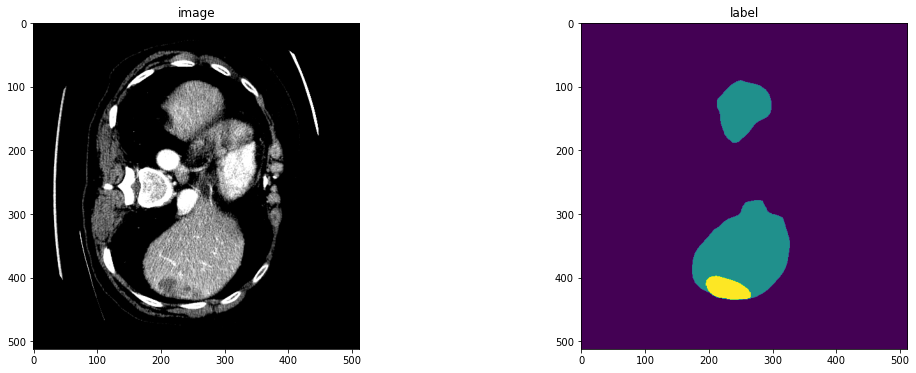

In [13]:
img = val_ds[0]["image"]
label = val_ds[0]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[ 0,:, :,-30].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, -30].detach().cpu())
plt.show()

torch.Size([1, 512, 512, 333])
[[306, 281, 281], [312, 51, 232], [265, 175, 273], [223, 119, 240], [236, 252, 242], [335, 77, 234], [281, 306, 229], [293, 49, 239], [171, 262, 258], [283, 251, 286]]


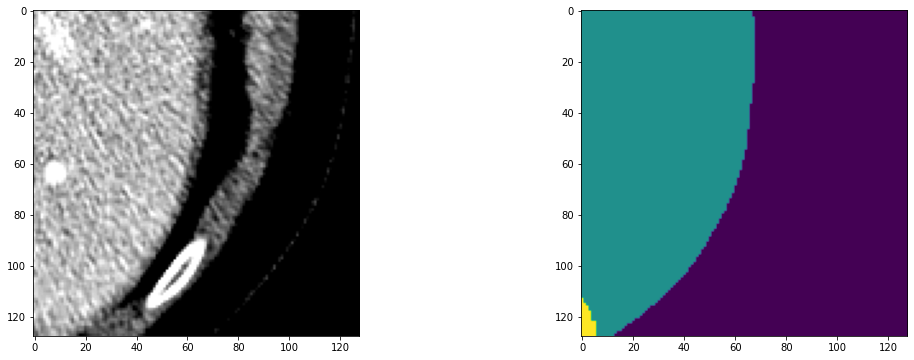

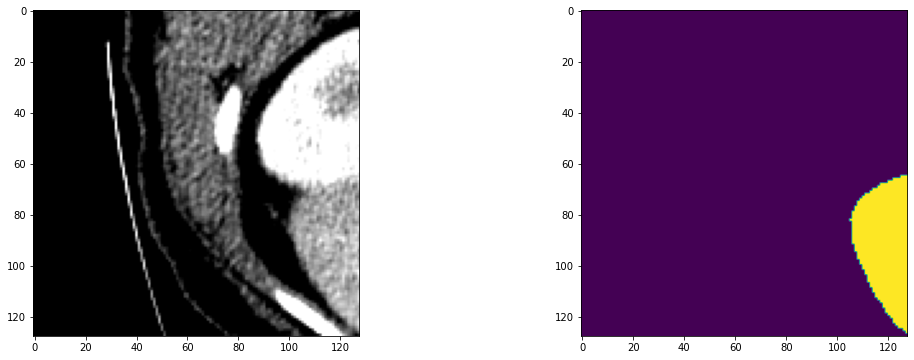

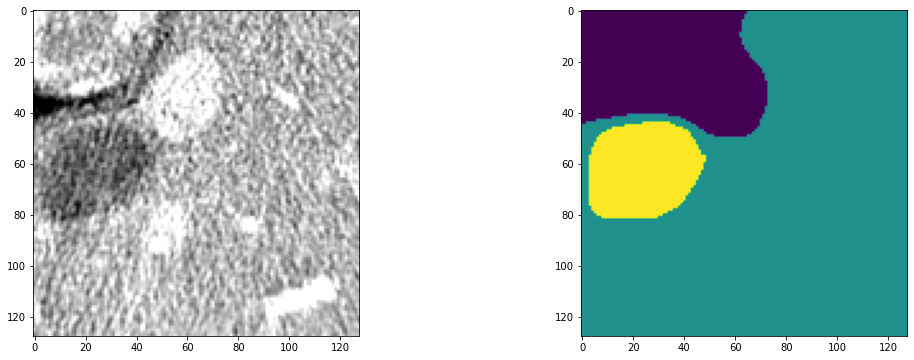

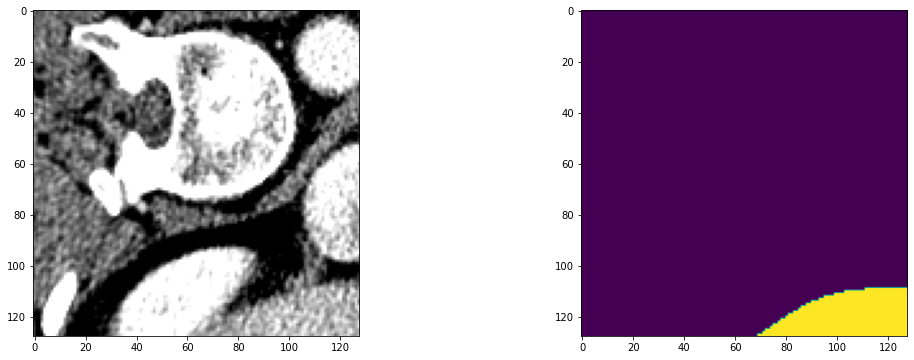

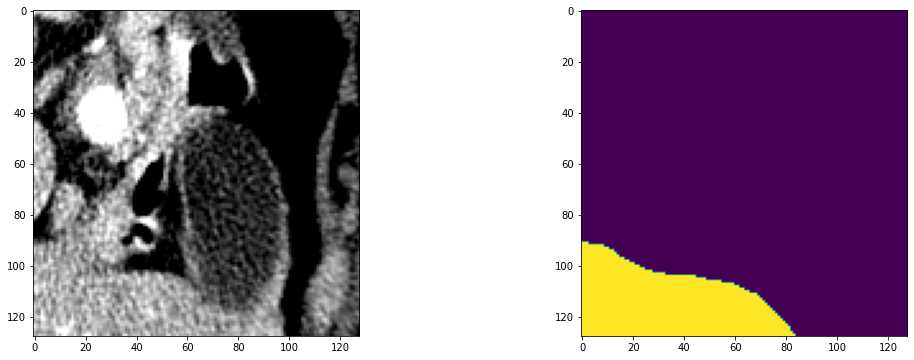

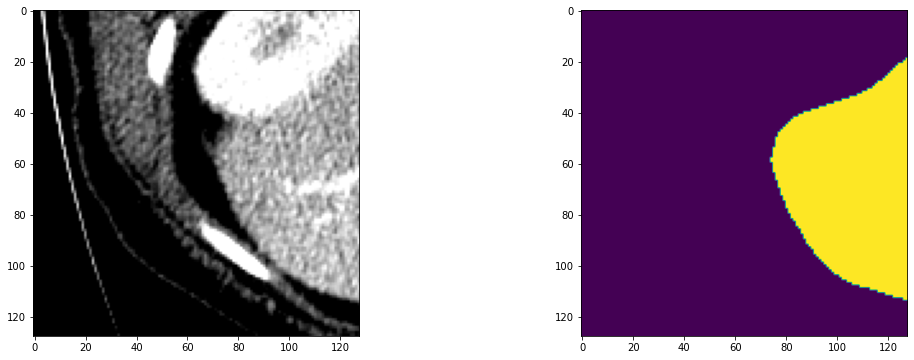

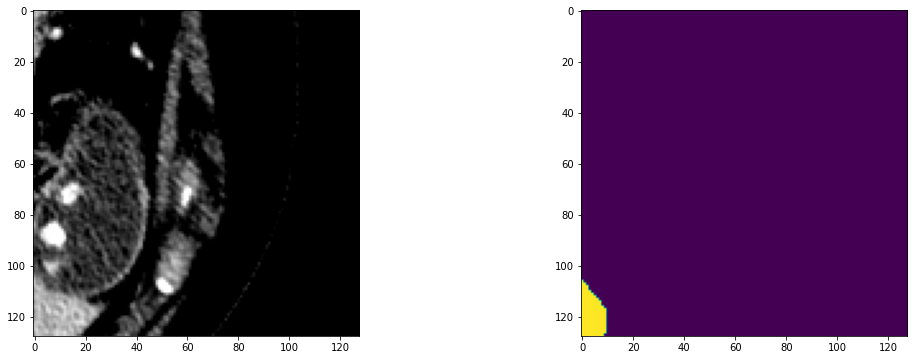

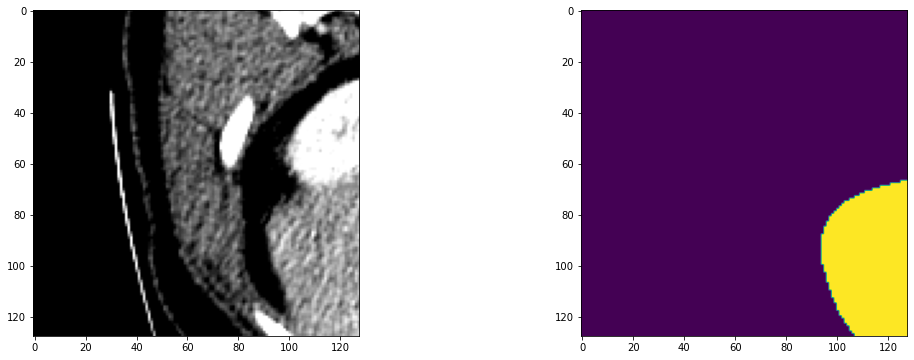

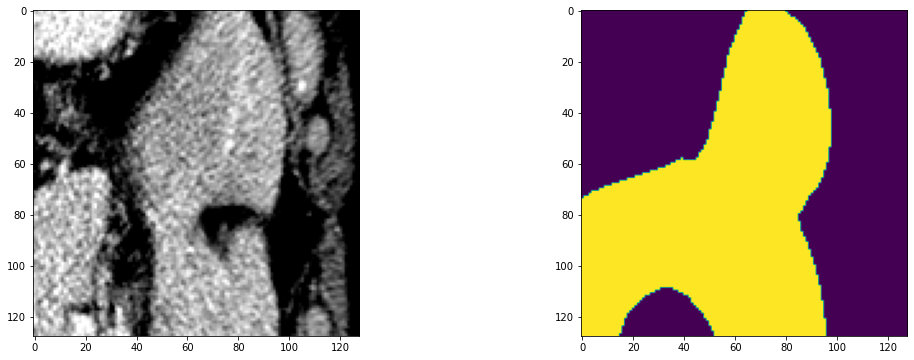

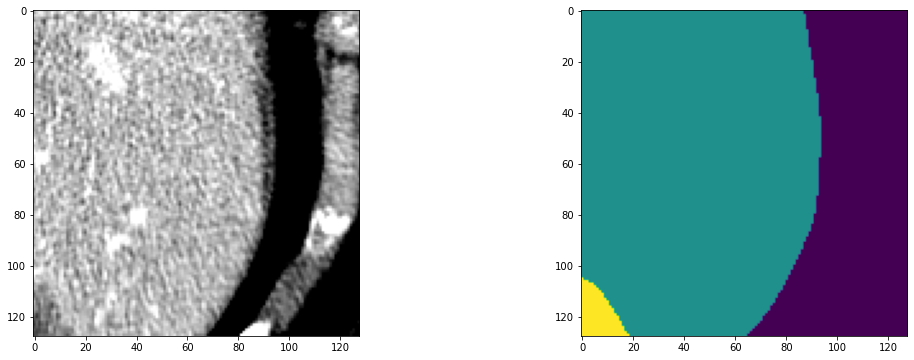

In [14]:
import numpy as np
from numpy import random
from monai.data import PatchDataset, DataLoader, PatchIter
inds=[]
def Crop_label(label):
    r=[]
    b=0
    liver=0
    tumor=0
    
    if label.shape[0]==1:
        label=label[0]
    x,y,z=label.shape
    while(tumor<10):
        i = random.randint(x-128)
        j = random.randint(y-128)
        k = random.randint(z-32)
        
       
        unique_num=np.unique(label[i:i+128,j:j+128,k:k+32])
        if 2 in unique_num and tumor<10:
            tumor=tumor+1
      
            inds.append([i,j,k])
        '''
        elif 2 not in unique_num and 1 in unique_num and liver<5:
            liver=liver+1
            inds.append([i,j,k])
        elif 2 not in unique_num and 1 not in unique_num and b<0:
            b=b+1
            inds.append([i,j,k])
       '''
    

    return  inds



def Crop_img(img):
    r=[]
    b=0
    liver=0
    tumor=0
    
    if img.shape[0]==1:
        img=img[0]
    x,y,z=img.shape
    for ind in inds:
        i,j,k=ind

        r.append(img[i:i+128,j:j+128,k:k+32])
         

    return r
            
# imaabsge-level dataset
img = val_ds[0]["image"]

print(img.shape)
label = val_ds[0]["label"]

# image patch sampler
n_samples = 10
# patch-level intensity shifts
# construct the patch dataset

inds=Crop_label(label)

ds_l = PatchDataset(data=label,
                  patch_func=Crop_img,
                  samples_per_image=n_samples)
print(inds)
ds_i = PatchDataset(data=img,
                  patch_func=Crop_img,
                  samples_per_image=n_samples)



val_loader1=DataLoader(ds_i, batch_size=1, shuffle=False, num_workers=1)
val_loader2=DataLoader(ds_l, batch_size=1, shuffle=False, num_workers=1)

#y=DataLoader(label_ds, batch_size=1, shuffle=False, num_workers=2)

for i,item1 in enumerate(zip(val_loader1,val_loader2)):
    plt.figure("image", (18, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(item1[0][0,:, :, 5].detach().cpu(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(item1[1][0,:, :, 5].detach().cpu())
    plt.show()



# **Check data shape and visualize**

In [77]:
from monai.networks.nets import TopologyInstance
from  monai.networks.nets import TopologySearch
from monai.networks.nets import AHNet,UNet,VNet
root_dir='/kaggle/working'
from monai.apps import load_from_mmar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# model=AHNet(layers=(2, 2,2,2), spatial_dims=3, in_channels=1, out_channels=3
#                                 , psp_block_num=1, upsample_mode='transpose', pretrained=True, progress=True).to(device)

model=VNet(spatial_dims=3, in_channels=1, out_channels=3).to(device)
'''
arch_mode=torch.load('/kaggle/input/search-code/search_code_18590.pt')
dints_space=TopologyInstance(
     channel_mul=1.0, 
      num_blocks=12,
     num_depths=4, spatial_dims=3, act_name='RELU',
      use_downsample=True, 
    arch_code=[arch_mode['arch_code_a'],arch_mode['arch_code_c']]).to(device)

model = DiNTS(dints_space, 1, 3, act_name='RELU',
 #model               spatial_dims=3, use_downsample=True, 
                node_a= torch.from_numpy(arch_mode['node_a'])).to(device)



model =UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels= (8,16,32,64),
    strides=(2,2,2),
).to(device)

'''

#model=BasicUNetPlusPlus(spatial_dims=3, in_channels=1, out_channels=3).to(device)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)



In [78]:


def validation(epoch_iterator_val):
    model.eval()
    val_labels_convert=[]
    val_outputs_convert=[]
    with torch.no_grad():
        for step,batch in enumerate(zip(val_loader1,val_loader2)):
            val_inputs,val_labels=batch
            val_inputs=val_inputs[None,:,:,:,:].cuda()
            val_labels=val_labels[ None,:, :,:,:].cuda()
            val_outputs = model(val_inputs)
            val_labels_convert.append(post_label(decollate_batch(val_labels)[0])[0])
            val_outputs_convert.append(post_pred(decollate_batch(val_outputs)[0])[0])
        dice_metric(y_pred=val_outputs_convert, y=val_labels_convert)
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    #model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader1, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                        "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                    )
            else:
                    print(
                        "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                            dice_val_best, dice_val
                        )
                    )
        global_step += 1
    return global_step, dice_val_best, global_step_best

max_iterations = 2000
eval_num = 50

post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

#m''''''odel.load_state_dict(torch.load('/kaggle/input/model-liver2/best_metric_model.pth'))
#model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
max_epochs = 10  # Define the maximum number of epochs

# Iterate through epochs
for epoch in range(max_epochs):
    # Inside each epoch, perform the training steps
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)

# After completing the specified number of epochs, load the best model
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
print(f"Training completed, best_metric: {dice_val_best:.4f} at iteration: {global_step_best}")

Training (50 / 2000 Steps) (loss=1.84297):  78%|███████▊  | 51/65 [04:28<01:24,  6.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.0 Current Avg. Dice: 0.0


Training (100 / 2000 Steps) (loss=1.60882):  55%|█████▌    | 36/65 [02:53<02:48,  5.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7107062339782715 Current Avg. Dice: 0.7107062339782715


Training (150 / 2000 Steps) (loss=1.46544):  32%|███▏      | 21/65 [01:42<04:17,  5.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8146297335624695 Current Avg. Dice: 0.8146297335624695


Training (200 / 2000 Steps) (loss=1.36844):   9%|▉         | 6/65 [00:32<05:51,  5.95s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8645660281181335 Current Avg. Dice: 0.8645660281181335


Training (250 / 2000 Steps) (loss=1.43401):  85%|████████▍ | 55/65 [04:25<00:46,  4.62s/it]

Training (250 / 2000 Steps) (loss=1.43401):  86%|████████▌ | 56/65 [04:29<00:51,  5.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9080173373222351 Current Avg. Dice: 0.9080173373222351


Training (300 / 2000 Steps) (loss=1.49512):  63%|██████▎   | 41/65 [03:15<02:13,  5.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9080173373222351 Current Avg. Dice: 0.8246147036552429


Training (350 / 2000 Steps) (loss=1.23679):  40%|████      | 26/65 [02:04<03:38,  5.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9080173373222351 Current Avg. Dice: 0.8947669863700867


Training (400 / 2000 Steps) (loss=1.40624):  17%|█▋        | 11/65 [00:55<05:24,  6.02s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9218673706054688 Current Avg. Dice: 0.9218673706054688


Training (450 / 2000 Steps) (loss=1.44623):  92%|█████████▏| 60/65 [04:49<00:23,  4.75s/it]

Training (450 / 2000 Steps) (loss=1.44623):  94%|█████████▍| 61/65 [04:53<00:22,  5.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9218673706054688 Current Avg. Dice: 0.8945389986038208


Training (500 / 2000 Steps) (loss=1.26736):  71%|███████   | 46/65 [03:39<01:52,  5.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9218673706054688 Current Avg. Dice: 0.9202593564987183


Training (550 / 2000 Steps) (loss=1.18762):  48%|████▊     | 31/65 [02:26<03:11,  5.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9218673706054688 Current Avg. Dice: 0.9115888476371765


Training (600 / 2000 Steps) (loss=1.18036):  25%|██▍       | 16/65 [01:18<04:39,  5.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9218673706054688 Current Avg. Dice: 0.921792209148407


Validate (X / X Steps) (dice=X.X):   0%|          | 0/10 [03:53<?, ?it/s]

Training completed, best_metric: 0.9219 at iteration: 400


In [82]:

#val_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)
test_ds =Dataset(
    data=test_files,
    transform=test_transforms,
)

In [83]:
import numpy as np
from monai.data import PatchDataset, DataLoader, PatchIter
def get_inds(img):
    inds=[]
    if img.shape[0]==1:
        img=img[0]
    x,y,z=img.shape
    for i in range(127,x,128):
        for j in range(127,y,128):
            for k in range(31,z,32):
                inds.append([i,j,k])
        
    return inds


img = test_ds[0]["image"].cuda()
indsf=get_inds(img)
label=torch.tensor(np.zeros(img.shape)).cuda()
for ind  in indsf:
    i,j,k=ind
    x=img[None,:,i-127:i+1,j-127:j+1,k-31:k+1]
    label[0,i-127:i+1,j-127:j+1,k-31:k+1]=torch.argmax(model(x),axis=1)

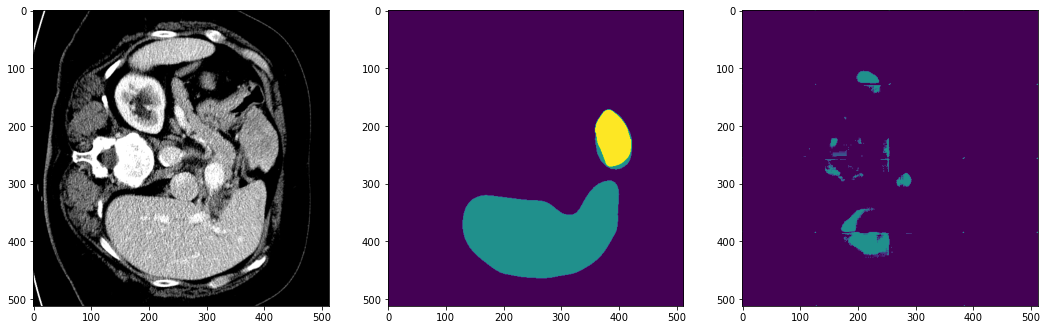

In [84]:
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.imshow(img[0,:, :, -25].detach().cpu(), cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(test_ds[0]["label"][0,:, :, -25].detach().cpu())
plt.subplot(1, 3, 3)

plt.imshow(label[0,:, :,-40].detach().cpu())
plt.show()

In [53]:
import torch
from monai.metrics import DiceMetric

# Initialize DiceMetric object
dice_metric = DiceMetric(include_background=True, reduction="mean")

# Create a list to store individual Dice scores
dice_scores = []

# Iterate through validation data
for step, batch in enumerate(zip(val_loader1, val_loader2)):
    val_inputs, val_labels = batch
    val_inputs = val_inputs[None, :, :, :, :].cuda()
    val_labels = val_labels[None, :, :, :, :].cuda()

    # Perform inference
    val_outputs = model(val_inputs)

    # Compute Dice scores
    dice_metric(y_pred=val_outputs, y=val_labels)
    dice_coefficients = dice_metric.aggregate()
    dice_scores.extend(dice_coefficients)

    # Reset DiceMetric object for the next batch
    dice_metric.reset()

# Compute mean Dice score
mean_dice_score = torch.mean(torch.tensor(dice_scores))

print(f"Mean Dice Score: {mean_dice_score}")


Mean Dice Score: 0.4191705584526062


In [56]:
from monai.metrics import MeanIoU

# Initialize MeanIoU object
mean_iou_metric = MeanIoU(include_background=True)

# Iterate through validation data
for step, batch in enumerate(zip(val_loader1, val_loader2)):
    val_inputs, val_labels = batch
    val_inputs = val_inputs[None, :, :, :, :].cuda()
    val_labels = val_labels[None, :, :, :, :].cuda()

    # Perform inference
    val_outputs = model(val_inputs)

    # Compute IoU scores
    mean_iou_metric(y_pred=val_outputs, y=val_labels)

# Aggregate the IoU scores
mean_iou_score = mean_iou_metric.aggregate()

print(f"Mean IoU Score: {mean_iou_score}")


ValueError: y_pred and y should have same shapes, got torch.Size([1, 3, 128, 128, 32]) and torch.Size([1, 1, 128, 128, 32]).